In [1]:
import io
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression 
from keras.utils import to_categorical

###########################################################################
#generate training/test data
########################################################################### 
bragging_file = io.open("cleantweets/Happy_clean.txt",'r',encoding="utf-8") 
bitching_file = io.open("cleantweets/FML_clean.txt",'r',encoding="utf-8") 
neither_file = io.open("cleantweets/Neither_clean.txt",'r',encoding="utf-8") 

training_samples = 30000
bragging_tweets = []
bitching_tweets = []
neither_tweets = []

for line in bragging_file:
    bragging_tweets.append(line.strip("\n"))
for line in bitching_file:
    bitching_tweets.append(line.strip("\n"))
for line in neither_file:
    neither_tweets.append(line.strip("\n"))

np.random.seed(42)
bragging_tweets = np.array(bragging_tweets)
bitching_tweets = np.array(bitching_tweets)
neither_tweets = np.array(neither_tweets)
np.random.shuffle(bragging_tweets)
np.random.shuffle(bitching_tweets)
np.random.shuffle(neither_tweets)

bi_data = []
br_data = []
for i in range(240000):
    bi_data.append([bitching_tweets[i],1])
    br_data.append([bragging_tweets[i],1])
    
for i in range(240000):
    bi_data.append([neither_tweets[i],0])
    br_data.append([neither_tweets[i],0])
    


np.random.shuffle(bi_data)
np.random.shuffle(br_data)

bi_tweets_train = np.array(bi_data[:336000])
bi_tweets_test = np.array(bi_data[336000:480000])

br_tweets_train = np.array(br_data[:336000])
br_tweets_test = np.array(br_data[336000:480000])

bi_X_train = bi_tweets_train[:,0]
bi_Y_train = to_categorical(bi_tweets_train[:,1])
bi_X_test = bi_tweets_test[:,0]
bi_Y_test = to_categorical(bi_tweets_test[:,1])

br_X_train = br_tweets_train[:,0]
br_Y_train = to_categorical(br_tweets_train[:,1])
br_X_test = br_tweets_test[:,0]
br_Y_test = to_categorical(br_tweets_test[:,1])

print(len(bi_X_train))
print(len(bi_Y_train))

print("Success")

C:\Users\aylme\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


336000
336000
Success


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 50
training_samples = 200000
max_words = 10000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(bi_X_train)
sequences = tokenizer.texts_to_sequences(bi_X_train)
word_index = tokenizer.word_index
print ('Found %s unique tokens.' % len(word_index))

Found 337459 unique tokens.


In [3]:
data = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(bi_Y_train)
print ("shape of the data tensor:", data.shape)
print ("shape of the label tensor: ", labels.shape)

shape of the data tensor: (336000, 50)
shape of the label tensor:  (336000, 2)


In [4]:
# splits data into a training set and a validation set
# indices = np.arange(data.shape[0])
# np.random.shuffle(indices)
# data = data[indices]
# labels = labels[indices]
import os

bi_x_train = data[:]
bi_y_train = labels[:]
# x_val = data[training_samples:]
# y_val = labels[training_samples:]

glove_dir = '/Users/aylme/workspace/CS175/glove.twitter.27B'
embeddings_index = {}
#your maxlen and you .txt files must correspond
f = open(os.path.join(glove_dir, 'glove.twitter.27B.50d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs=np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.'%len(embeddings_index))

Found 1193514 word vectors.


In [5]:
embedding_dim = maxlen
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if (i < max_words):
        embedding_vector= embeddings_index.get(word)
        if (embedding_vector is not None):
            embedding_matrix[i] = embedding_vector
            

In [6]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

bi_model = Sequential()
bi_model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
bi_model.add(Flatten())
bi_model.add(Dense(32, activation = 'relu'))
bi_model.add(Dense(2, activation = 'softmax'))
bi_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                80032     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 580,098
Trainable params: 580,098
Non-trainable params: 0
_________________________________________________________________


In [7]:
#bi_model.layers[0].set_weights([embedding_matrix])
#bi_model.layers[0].trainable = False

In [8]:
import keras.optimizers
sgd = keras.optimizers.SGD(lr=0.0001*400)
bi_model.compile(optimizer = sgd,
             loss = 'categorical_crossentropy',
             metrics = ['acc'])

bi_history = bi_model.fit(bi_x_train, bi_y_train, epochs = 3, batch_size= 32, validation_split = 0.1 )
bi_model.save_weights('bi_pre-trained_glove_twitter_model.h5')

Train on 302400 samples, validate on 33600 samples
Epoch 1/3
302400/302400 [==============================] - 123s 406us/step - loss: 0.1993 - acc: 0.9159 - val_loss: 0.1321 - val_acc: 0.9517
Epoch 2/3
302400/302400 [==============================] - 119s 394us/step - loss: 0.1113 - acc: 0.9595 - val_loss: 0.1088 - val_acc: 0.9602
Epoch 3/3
302400/302400 [==============================] - 121s 400us/step - loss: 0.0982 - acc: 0.9642 - val_loss: 0.1042 - val_acc: 0.9621


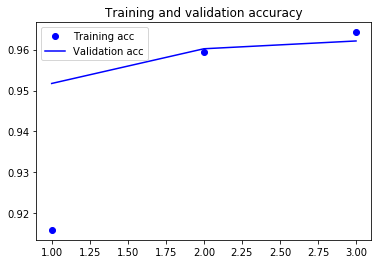

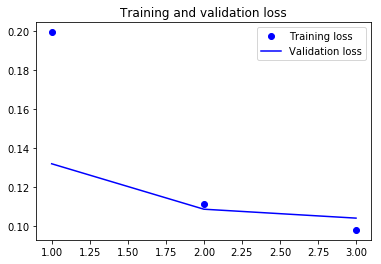

In [9]:
import matplotlib.pyplot as plt
acc = bi_history.history['acc']
val_acc = bi_history.history['val_acc']
loss = bi_history.history['loss']
val_loss = bi_history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
## These will be results on the test
sequences = tokenizer.texts_to_sequences(bi_X_test)
bi_x_test = pad_sequences(sequences, maxlen = maxlen)
bi_y_test = np.asarray(bi_Y_test)
bi_model.load_weights('bi_pre-trained_glove_twitter_model.h5')
bi_model.evaluate(bi_x_test, bi_y_test)

144000/144000 [==============================] - 12s 80us/step


[0.10447153980222841, 0.961625]

In [11]:
##################################################################################
#BRAGGING MODEL
##################################################################################

In [12]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(br_X_train)
sequences = tokenizer.texts_to_sequences(br_X_train)
word_index = tokenizer.word_index
print ('Found %s unique tokens.' % len(word_index))

Found 386728 unique tokens.


In [13]:
data = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(br_Y_train)
print ("shape of the data tensor:", data.shape)
print ("shape of the label tensor: ", labels.shape)

shape of the data tensor: (336000, 50)
shape of the label tensor:  (336000, 2)


In [14]:
br_x_train = data[:]
br_y_train = labels[:]
# x_val = data[training_samples:]
# y_val = labels[training_samples:]

glove_dir = '/Users/aylme/workspace/CS175/glove.twitter.27B'
embeddings_index = {}
#your maxlen and you .txt files must correspond
f = open(os.path.join(glove_dir, 'glove.twitter.27B.50d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs=np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.'%len(embeddings_index))

Found 1193514 word vectors.


In [15]:
embedding_dim = maxlen
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if (i < max_words):
        embedding_vector= embeddings_index.get(word)
        if (embedding_vector is not None):
            embedding_matrix[i] = embedding_vector

In [16]:
br_model = Sequential()
br_model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
br_model.add(Flatten())
br_model.add(Dense(32, activation = 'relu'))
br_model.add(Dense(2, activation = 'softmax'))
br_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            500000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                80032     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 580,098
Trainable params: 580,098
Non-trainable params: 0
_________________________________________________________________


In [17]:
#br_model.layers[0].set_weights([embedding_matrix])
#br_model.layers[0].trainable = False

In [18]:
br_model.compile(optimizer = sgd,
             loss = 'categorical_crossentropy',
             metrics = ['acc'])

br_history = br_model.fit(br_x_train, br_y_train, epochs = 3, batch_size= 32, validation_split = 0.1 )
br_model.save_weights('br_pre-trained_glove_twitter_model.h5')

Train on 302400 samples, validate on 33600 samples
Epoch 1/3
302400/302400 [==============================] - 125s 413us/step - loss: 0.2454 - acc: 0.8895 - val_loss: 0.1688 - val_acc: 0.9328
Epoch 2/3
302400/302400 [==============================] - 120s 396us/step - loss: 0.1619 - acc: 0.9349 - val_loss: 0.1628 - val_acc: 0.9340
Epoch 3/3
302400/302400 [==============================] - 120s 395us/step - loss: 0.1473 - acc: 0.9411 - val_loss: 0.1601 - val_acc: 0.9363


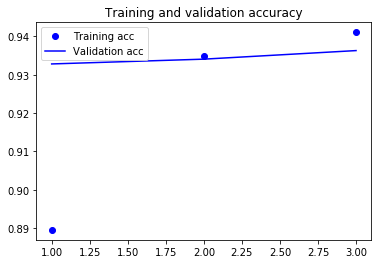

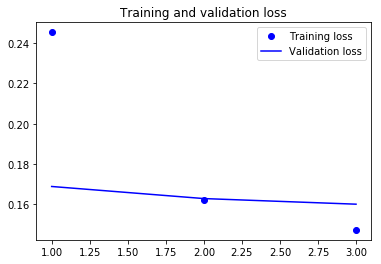

In [19]:
acc = br_history.history['acc']
val_acc = br_history.history['val_acc']
loss = br_history.history['loss']
val_loss = br_history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
sequences = tokenizer.texts_to_sequences(br_X_test)
br_x_test = pad_sequences(sequences, maxlen = maxlen)
br_y_test = np.asarray(br_Y_test)
br_model.load_weights('br_pre-trained_glove_twitter_model.h5')
br_model.evaluate(br_x_test, br_y_test)

144000/144000 [==============================] - 16s 113us/step


[0.1598797175321314, 0.9346944444444445]

In [32]:
def predict(bi_pred, br_pred):
    predictions = []
    for i in range(len(bi_pred)):
        if bi_pred[i][0]>=0.5 and br_pred[i][0]>=0.5:
            if abs(bi_pred[i][0]-br_pred[i][0])<0.1:
                predictions.append("BOTH")
            elif bi_pred[i][0]>br_pred[i][0]:
                predictions.append("BITCHING")
            elif bi_pred[i][0]<br_pred[i][0]:
                predictions.append("BRAGGING")
        elif bi_pred[i][0]>=0.5 and br_pred[i][0]<=0.5:
            predictions.append("BITCHING")
        elif bi_pred[i][0]<=0.5 and br_pred[i][0]>=0.5:
            predictions.append("BRAGGING")
        elif bi_pred[i][0]<=0.5 and br_pred[i][0]<=0.5:
            predictions.append("NEITHER")   
    return predictions

In [33]:
test_tweets = ["The decision on Sergeant Bergdahl is a complete and total disgrace to our Country and to our Military.",
                "Does anybody really believe that a reporter, who nobody ever heard of, went to his mailbox and found my tax returns? @NBCNews FAKE NEWS!",
                "After Turkey call I will be heading over to Trump National Golf Club, Jupiter, to play golf (quickly) with Tiger Woods and Dustin Johnson. Then back to Mar-a-Lago for talks on bringing even more jobs and companies back to the USA!",
                "“The President has accomplished some absolutely historic things during this past year.” Thank you Charlie Kirk of Turning Points USA. Sadly, the Fake Mainstream Media will NEVER talk about our accomplishments in their end of year reviews. We are compiling a long & beautiful list."]
sequences = tokenizer.texts_to_sequences(test_tweets)
x_test = pad_sequences(sequences, maxlen = maxlen)
br_model.load_weights('br_pre-trained_glove_twitter_model.h5')
br_pred=br_model.predict(x_test)
bi_model.load_weights('bi_pre-trained_glove_twitter_model.h5')
bi_pred=bi_model.predict(x_test)

predictions=predict(bi_pred,br_pred)
for i in range(len(test_tweets)):
    print("("+predictions[i]+")  "+test_tweets[i])


(BITCHING)  The decision on Sergeant Bergdahl is a complete and total disgrace to our Country and to our Military.
(BITCHING)  Does anybody really believe that a reporter, who nobody ever heard of, went to his mailbox and found my tax returns? @NBCNews FAKE NEWS!
(BRAGGING)  After Turkey call I will be heading over to Trump National Golf Club, Jupiter, to play golf (quickly) with Tiger Woods and Dustin Johnson. Then back to Mar-a-Lago for talks on bringing even more jobs and companies back to the USA!
(BOTH)  “The President has accomplished some absolutely historic things during this past year.” Thank you Charlie Kirk of Turning Points USA. Sadly, the Fake Mainstream Media will NEVER talk about our accomplishments in their end of year reviews. We are compiling a long & beautiful list.
